In [1]:
# DROP-IN: load dataset from csv_path (or use cached parquet / in-memory df), downsample, compute RUL/duration/event
import os
import pandas as pd
import numpy as np

# --- User-editable path (keeps your original variable if present) ---
csv_path = globals().get("csv_path", "content/MetroPT3(AirCompressor).csv")
cache_dir = globals().get("cache_dir", "content/parquet_cache")
os.makedirs(cache_dir, exist_ok=True)

# --- Failure events source: prefer existing failure_starts or fail_tbl if present ---
if 'failure_starts' in globals():
    failure_list = failure_starts
elif 'fail_tbl' in globals() and 'failure_start' in fail_tbl.columns:
    failure_list = pd.to_datetime(fail_tbl['failure_start']).tolist()
else:
    failure_list = [
        pd.to_datetime("2020-04-18 00:00", utc=True),
        pd.to_datetime("2020-05-29 23:30", utc=True),
        pd.to_datetime("2020-06-05 10:00", utc=True),
        pd.to_datetime("2020-07-15 14:30", utc=True)
    ]
    print("[INFO] Using embedded failure_list; replace with your own if different.")

# --- 1) If df already in memory, keep it (skip heavy IO) ---
if 'df' in globals() and isinstance(df, pd.DataFrame) and "timestamp" in df.columns:
    print("[INFO] Using existing `df` in memory with shape:", df.shape)
else:
    # 2) Try to load cached parquet parts if they exist
    parts = sorted([os.path.join(cache_dir, p) for p in os.listdir(cache_dir) if p.endswith(".parquet")]) if os.path.isdir(cache_dir) else []
    if parts:
        print("[INFO] Loading cached parquet parts:", parts)
        df = pd.concat((pd.read_parquet(p) for p in parts), ignore_index=True)
        df = df.drop_duplicates(subset=["timestamp"]).sort_values("timestamp").ffill().bfill().reset_index(drop=True)
        print("[INFO] Loaded df from parquet cache with shape:", df.shape)
    else:
        # 3) Read CSV in chunks, downsample to 1h, cache parquet parts
        if not os.path.exists(csv_path):
            raise RuntimeError(f"CSV not found at {csv_path}. Update csv_path or provide cached parquet in {cache_dir}.")
        print(f"[INFO] Reading CSV in chunks from {csv_path}, downsampling to 1h, caching to {cache_dir} ...")
        chunk_iter = pd.read_csv(csv_path, chunksize=500_000, low_memory=True)
        part_paths = []
        for i, chunk in enumerate(chunk_iter):
            # ensure timestamp exists and parse
            if "timestamp" not in chunk.columns:
                raise RuntimeError("CSV missing 'timestamp' column; ensure your CSV has a timestamp column.")
            chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], errors="coerce", utc=True)
            chunk = chunk.dropna(subset=["timestamp"])
            # downsample to 1h (mean aggregation for numeric columns)
            chunk = chunk.set_index("timestamp").resample("1h").mean().dropna().reset_index()
            out_path = os.path.join(cache_dir, f"part_{i:03d}.parquet")
            chunk.to_parquet(out_path, index=False)
            part_paths.append(out_path)
            print(f"[INFO] Cached part {i} -> {out_path} ({len(chunk)} rows)")
        # concatenate cached parts
        if len(part_paths) == 0:
            raise RuntimeError("No data read from CSV; check csv_path and file contents.")
        df = pd.concat((pd.read_parquet(p) for p in sorted(part_paths)), ignore_index=True)
        df = df.drop_duplicates(subset=["timestamp"]).sort_values("timestamp").ffill().bfill().reset_index(drop=True)
        print("[INFO] Final downsampled dataset shape:", df.shape)

# --- Ensure timestamp dtype and timezone consistency ---
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
if df["timestamp"].dt.tz is None:
    df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")
else:
    df["timestamp"] = df["timestamp"].dt.tz_convert("UTC")

# --- Normalize failure_list to timezone-aware UTC and sort ---
failure_list = [pd.to_datetime(f) for f in failure_list]
failure_list = [f.tz_convert("UTC") if getattr(f, "tzinfo", None) is not None else f.tz_localize("UTC") for f in failure_list]
failure_list = sorted(failure_list)

# --- Compute next_failure and RUL_hours using merge_asof (forward) ---
fail_df = pd.DataFrame({"next_failure": failure_list}).sort_values("next_failure").reset_index(drop=True)
df = df.sort_values("timestamp").reset_index(drop=True)
df = pd.merge_asof(df, fail_df, left_on="timestamp", right_on="next_failure", direction="forward")

df["RUL_hours"] = (df["next_failure"] - df["timestamp"]).dt.total_seconds() / 3600.0
df["RUL_hours"] = df["RUL_hours"].where(df["next_failure"].notna(), np.nan)
df.loc[df["RUL_hours"] < 0, "RUL_hours"] = 0.0

# --- Create duration and event for survival modeling ---
dataset_end = df["timestamp"].max()
mask_censored = df["RUL_hours"].isna()
df.loc[mask_censored, "duration"] = (dataset_end - df.loc[mask_censored, "timestamp"]).dt.total_seconds() / 3600.0
df.loc[~mask_censored, "duration"] = df.loc[~mask_censored, "RUL_hours"]
df["event"] = (~df["RUL_hours"].isna()).astype(int)
df["duration"] = df["duration"].clip(lower=0.0)

# --- Final sanity prints ---
n_total = len(df)
n_events = int(df["event"].sum())
n_censored = n_total - n_events
print(f"[INFO] Dataset ready. Rows: {n_total}, events: {n_events}, censored: {n_censored}")
print("Time range:", df["timestamp"].min(), "→", df["timestamp"].max())
print("Sample rows:")
display(df.head())

# Expose variables for downstream cells
# df, failure_starts (update), cache_dir remain available
failure_starts = failure_list


[INFO] Using embedded failure_list; replace with your own if different.
[INFO] Loading cached parquet parts: ['content/parquet_cache/part_000.parquet', 'content/parquet_cache/part_001.parquet', 'content/parquet_cache/part_002.parquet', 'content/parquet_cache/part_003.parquet']
[INFO] Loaded df from parquet cache with shape: (1516948, 17)
[INFO] Dataset ready. Rows: 1516948, events: 1171094, censored: 345854
Time range: 2020-02-01 00:00:00+00:00 → 2020-09-01 03:59:50+00:00
Sample rows:


,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,...,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,next_failure,RUL_hours,duration,event
0,0,2020-02-01 00:00:00+00:00,-0.012,9.358,9.340,-0.024,9.358,53.599998,0.0400,1,...,1.0,1,0,1.0,1.0,1.0,2020-04-18 00:00:00+00:00,1848.000000,1848.000000,1
1,10,2020-02-01 00:00:10+00:00,-0.014,9.348,9.332,-0.022,9.348,53.674999,0.0400,1,...,1.0,1,0,1.0,1.0,1.0,2020-04-18 00:00:00+00:00,1847.997222,1847.997222,1
2,20,2020-02-01 00:00:19+00:00,-0.012,9.338,9.322,-0.022,9.338,53.599998,0.0425,1,...,1.0,1,0,1.0,1.0,1.0,2020-04-18 00:00:00+00:00,1847.994722,1847.994722,1
3,30,2020-02-01 00:00:29+00:00,-0.012,9.328,9.312,-0.022,9.328,53.424999,0.0400,1,...,1.0,1,0,1.0,1.0,1.0,2020-04-18 00:00:00+00:00,1847.991944,1847.991944,1
4,40,2020-02-01 00:00:39+00:00,-0.012,9.318,9.302,-0.022,9.318,53.474998,0.0400,1,...,1.0,1,0,1.0,1.0,1.0,2020-04-18 00:00:00+00:00,1847.989167,1847.989167,1


In [2]:
# Install and import survival libraries if missing
import sys, subprocess, importlib

def pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# Try to import lifelines (lightweight, pure Python)
try:
    import lifelines
    print("lifelines available:", lifelines.__version__)
except Exception:
    print("Installing lifelines...")
    pip_install("lifelines==0.27.4")
    import lifelines
    print("lifelines installed:", lifelines.__version__)

# Try to import scikit-survival (optional, faster RSF/GBS)
have_sksurv = False
try:
    import sksurv
    have_sksurv = True
    print("scikit-survival available")
except Exception:
    print("scikit-survival not found; attempting install (may take a minute)...")
    try:
        pip_install("scikit-survival")
        import sksurv
        have_sksurv = True
        print("scikit-survival installed")
    except Exception as e:
        print("scikit-survival install failed or not available in this environment:", e)
        have_sksurv = False

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# Metrics
from lifelines.utils import concordance_index
from sklearn.metrics import mean_absolute_error

print("Setup complete. scikit-survival available:", have_sksurv)


lifelines available: 0.30.0
scikit-survival available
Setup complete. scikit-survival available: True


In [3]:
# Robust replacement for computing next_failure and RUL_hours
import numpy as np
import pandas as pd

# Preconditions: df exists and failure_starts is a non-empty list of datetimes
if 'df' not in globals():
    raise RuntimeError("`df` not found. Run the preprocessing cell first.")
if 'failure_starts' not in globals() or len(failure_starts) == 0:
    raise RuntimeError("`failure_starts` missing or empty. Provide failure timestamps.")

# Work on a copy and ensure timestamp dtype
df = df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
if df['timestamp'].isna().any():
    df = df.dropna(subset=['timestamp']).reset_index(drop=True)

# Normalize failure_starts to pandas Timestamps and ensure UTC
failure_list = [pd.to_datetime(f) for f in failure_starts]
failure_list = [f.tz_convert('UTC') if getattr(f, 'tzinfo', None) is not None else f.tz_localize('UTC') for f in failure_list]
failure_list = sorted(failure_list)

# Convert failure_list and timestamps to numpy datetime64[ns] (tz info will be removed for searchsorted)
fail_arr = np.array([pd.Timestamp(f).to_datetime64() for f in failure_list], dtype='datetime64[ns]')
ts = df['timestamp'].values.astype('datetime64[ns]')

# Use searchsorted to find index of first failure >= timestamp
idxs = np.searchsorted(fail_arr, ts, side='left')

# Build next_failure array (datetime64[ns]) with NaT where no future failure exists
next_failure = np.empty(len(idxs), dtype='datetime64[ns]')
for i, idx in enumerate(idxs):
    if idx >= len(fail_arr):
        next_failure[i] = np.datetime64('NaT')
    else:
        next_failure[i] = fail_arr[idx]

# Assign as pandas Series, then localize to UTC (Series.dt exists)
df['next_failure'] = pd.to_datetime(next_failure)            # yields tz-naive DatetimeIndex/Series
df['next_failure'] = df['next_failure'].dt.tz_localize('UTC')  # now timezone-aware UTC; NaT preserved

# Compute RUL_hours and survival columns
df['RUL_hours'] = (df['next_failure'] - df['timestamp']).dt.total_seconds() / 3600.0
df['RUL_hours'] = df['RUL_hours'].where(df['next_failure'].notna(), np.nan)
df.loc[df['RUL_hours'] < 0, 'RUL_hours'] = 0.0

dataset_end = df['timestamp'].max()
mask_censored = df['RUL_hours'].isna()
df.loc[mask_censored, 'duration'] = (dataset_end - df.loc[mask_censored, 'timestamp']).dt.total_seconds() / 3600.0
df.loc[~mask_censored, 'duration'] = df.loc[~mask_censored, 'RUL_hours']
df['event'] = (~df['RUL_hours'].isna()).astype(int)
df['duration'] = df['duration'].clip(lower=0.0)

# Quick sanity output
n_total = len(df)
n_events = int(df['event'].sum())
n_censored = n_total - n_events
print(f"[INFO] next_failure and RUL_hours computed. Rows: {n_total}, events: {n_events}, censored: {n_censored}")
display(df[['timestamp','next_failure','RUL_hours','duration','event']].head(8))


[INFO] next_failure and RUL_hours computed. Rows: 1516948, events: 1171094, censored: 345854


,timestamp,next_failure,RUL_hours,duration,event
0,2020-02-01 00:00:00+00:00,2020-04-18 00:00:00+00:00,1848.000000,1848.000000,1
1,2020-02-01 00:00:10+00:00,2020-04-18 00:00:00+00:00,1847.997222,1847.997222,1
2,2020-02-01 00:00:19+00:00,2020-04-18 00:00:00+00:00,1847.994722,1847.994722,1
3,2020-02-01 00:00:29+00:00,2020-04-18 00:00:00+00:00,1847.991944,1847.991944,1
4,2020-02-01 00:00:39+00:00,2020-04-18 00:00:00+00:00,1847.989167,1847.989167,1
5,2020-02-01 00:00:49+00:00,2020-04-18 00:00:00+00:00,1847.986389,1847.986389,1
6,2020-02-01 00:00:59+00:00,2020-04-18 00:00:00+00:00,1847.983611,1847.983611,1
7,2020-02-01 00:01:09+00:00,2020-04-18 00:00:00+00:00,1847.980833,1847.980833,1


In [4]:
# DROP-IN FIX: prepare surv_df with features for survival modeling
import pandas as pd
import numpy as np

# Preconditions: df must exist and contain timestamp, duration, event
if 'df' not in globals():
    raise RuntimeError("`df` not found. Run the RUL computation cell first.")
required_cols = {'timestamp','duration','event'}
if not required_cols.issubset(set(df.columns)):
    raise RuntimeError(f"df must contain columns: {required_cols}")

# Choose sensor columns (adjust if your dataset has different names)
sensor_cols = ["Motor_current","Oil_temperature","TP2","TP3","H1","DV_pressure","Reservoirs"]
# Ensure sensors exist; if missing, create zero columns to keep shapes consistent
for s in sensor_cols:
    if s not in df.columns:
        df[s] = 0.0

# Build lightweight features per row (short EWMs, deltas, rolling stats)
ewm_spans = [1,3]   # keep short spans for responsiveness
roll_w = 3

df_feat = df.copy().reset_index(drop=True)
for col in sensor_cols:
    x = df_feat[col].astype(float)
    df_feat[f"{col}_z"] = (x - x.mean()) / (x.std() if x.std() != 0 else 1.0)
    for span in ewm_spans:
        df_feat[f"{col}_ewm_{span}"] = x.ewm(span=span, adjust=False).mean()
    df_feat[f"{col}_delta1"] = x.diff(1).fillna(0.0)
    df_feat[f"{col}_delta3"] = x.diff(3).fillna(0.0)
    df_feat[f"{col}_roll_max_{roll_w}"] = x.rolling(roll_w, min_periods=1).max()
    df_feat[f"{col}_roll_min_{roll_w}"] = x.rolling(roll_w, min_periods=1).min()
    df_feat[f"{col}_roll_range_{roll_w}"] = df_feat[f"{col}_roll_max_{roll_w}"] - df_feat[f"{col}_roll_min_{roll_w}"]

# Select feature columns (exclude timestamp, next_failure, RUL_hours, duration, event)
exclude = {'timestamp','next_failure','RUL_hours','duration','event'}
feature_cols = [c for c in df_feat.columns if c not in exclude and c not in ['index'] and c != 'timestamp' and c not in ['duration','event'] and any(s in c for s in sensor_cols)]
feature_cols = sorted(list(set(feature_cols)))  # unique sorted list

# Build surv_df
surv_df = df_feat[['timestamp','duration','event'] + feature_cols].copy()
surv_df = surv_df.fillna(method='ffill').fillna(method='bfill').fillna(0.0)

print(f"[INFO] surv_df prepared with {len(feature_cols)} features and shape {surv_df.shape}")
print("Feature sample:", feature_cols[:10])
display(surv_df.head())


/var/folders/45/8twnqvqn4p36dwf0dbjmhkh00000gn/T/ipykernel_2986/2146992450.py:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  surv_df = surv_df.fillna(method='ffill').fillna(method='bfill').fillna(0.0)


[INFO] surv_df prepared with 63 features and shape (1516948, 66)
Feature sample: ['DV_pressure', 'DV_pressure_delta1', 'DV_pressure_delta3', 'DV_pressure_ewm_1', 'DV_pressure_ewm_3', 'DV_pressure_roll_max_3', 'DV_pressure_roll_min_3', 'DV_pressure_roll_range_3', 'DV_pressure_z', 'H1']


,timestamp,duration,event,DV_pressure,DV_pressure_delta1,DV_pressure_delta3,DV_pressure_ewm_1,DV_pressure_ewm_3,DV_pressure_roll_max_3,DV_pressure_roll_min_3,...,TP2_z,TP3,TP3_delta1,TP3_delta3,TP3_ewm_1,TP3_ewm_3,TP3_roll_max_3,TP3_roll_min_3,TP3_roll_range_3,TP3_z
0,2020-02-01 00:00:00+00:00,1848.000000,1,-0.024,0.000,0.000,-0.024,-0.024000,-0.024,-0.024,...,-0.424440,9.358,0.000000,0.00,9.358,9.358000,9.358,9.358,0.00,0.584247
1,2020-02-01 00:00:10+00:00,1847.997222,1,-0.022,0.002,0.000,-0.022,-0.023000,-0.022,-0.024,...,-0.425056,9.348,-0.010000,0.00,9.348,9.353000,9.358,9.348,0.01,0.568599
2,2020-02-01 00:00:19+00:00,1847.994722,1,-0.022,0.000,0.000,-0.022,-0.022500,-0.022,-0.024,...,-0.424440,9.338,-0.009999,0.00,9.338,9.345500,9.358,9.338,0.02,0.552953
3,2020-02-01 00:00:29+00:00,1847.991944,1,-0.022,0.000,0.002,-0.022,-0.022250,-0.022,-0.022,...,-0.424440,9.328,-0.010000,-0.03,9.328,9.336750,9.348,9.328,0.02,0.537306
4,2020-02-01 00:00:39+00:00,1847.989167,1,-0.022,0.000,0.000,-0.022,-0.022125,-0.022,-0.022,...,-0.424440,9.318,-0.010000,-0.03,9.318,9.327375,9.338,9.318,0.02,0.521658


In [5]:
# DROP-IN FIX: train CoxPH and optional RSF on surv_df (lightweight)
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Preconditions
if 'surv_df' not in globals():
    raise RuntimeError("`surv_df` not found. Run the surv_df preparation cell first.")

# Temporal train/test split by timestamp (70/30)
split_time = surv_df['timestamp'].quantile(0.70)
train_df = surv_df[surv_df['timestamp'] <= split_time].reset_index(drop=True)
test_df  = surv_df[surv_df['timestamp'] > split_time].reset_index(drop=True)
print(f"[INFO] Train rows: {len(train_df)}, Test rows: {len(test_df)}")

# Prepare lifelines DataFrames
train_lf = train_df.drop(columns=['timestamp']).copy()
test_lf  = test_df.drop(columns=['timestamp']).copy()

# Fit CoxPH with small penalizer for stability
cph = CoxPHFitter(penalizer=0.1)
cph.fit(train_lf, duration_col='duration', event_col='event', show_progress=False)
print("[INFO] CoxPH fitted. Top coefficients:")
display(cph.summary.sort_values('p').head(10))

# Predict survival function grid for test set and compute median survival time per row
max_time = max(test_lf['duration'].max(), train_lf['duration'].max(), 1.0)
time_grid = np.linspace(0.0, max_time, 200)
surv_funcs = cph.predict_survival_function(test_lf.drop(columns=['duration','event']), times=time_grid)

# For each test row (column), find first time where survival <= 0.5 (median)
pred_median_cox = []
for col in surv_funcs.columns:
    s = surv_funcs[col].to_numpy()
    idx = np.where(s <= 0.5)[0]
    if len(idx) == 0:
        pred_median_cox.append(time_grid[-1])
    else:
        pred_median_cox.append(time_grid[idx[0]])
pred_median_cox = np.array(pred_median_cox)

# Evaluate CoxPH median vs actual duration
y_true = test_lf['duration'].to_numpy()
mae_cox = mean_absolute_error(y_true, pred_median_cox)
cindex_cox = concordance_index(y_true, -pred_median_cox, test_lf['event'].to_numpy())
print(f"[RESULT] CoxPH median MAE = {mae_cox:.2f} hours; C-index = {cindex_cox:.3f}")

# Optional: try scikit-survival Random Survival Forest if available (lightweight)
rsf_pred_median = None
if 'sksurv' in globals():
    try:
        from sksurv.ensemble import RandomSurvivalForest
        from sksurv.util import Surv
        X_train = train_lf.drop(columns=['duration','event']).to_numpy()
        X_test  = test_lf.drop(columns=['duration','event']).to_numpy()
        y_train_struct = Surv.from_dataframe('event','duration', train_lf)
        rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
        rsf.fit(X_train, y_train_struct)
        surv_funcs_rsf = rsf.predict_survival_function(X_test, return_array=False)
        # evaluate median per sample on same time_grid
        rsf_medians = []
        for fn in surv_funcs_rsf:
            vals = fn(time_grid)
            idx = np.where(vals <= 0.5)[0]
            if len(idx) == 0:
                rsf_medians.append(time_grid[-1])
            else:
                rsf_medians.append(time_grid[idx[0]])
        rsf_pred_median = np.array(rsf_medians)
        mae_rsf = mean_absolute_error(y_true, rsf_pred_median)
        cindex_rsf = concordance_index(y_true, -rsf_pred_median, test_lf['event'].to_numpy())
        print(f"[RESULT] RSF median MAE = {mae_rsf:.2f}; C-index = {cindex_rsf:.3f}")
    except Exception as e:
        print("[WARN] scikit-survival RSF training failed or not available:", e)

# Expose outputs for downstream evaluation cells
models = {'cph': cph}
predictions = {'cox_median': pred_median_cox, 'rsf_median': rsf_pred_median}
train_split = train_df
test_split = test_df

print("[INFO] Models and predictions available: models, predictions, train_split, test_split")


[INFO] Train rows: 1061863, Test rows: 455085
[INFO] CoxPH fitted. Top coefficients:


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Oil_temperature_roll_range_3,0.146723,1.158033,0.001908,0.142983,0.150462,1.153710,1.162371,0.0,76.905043,0.000000e+00,inf
Oil_temperature_ewm_3,0.011701,1.011770,0.000422,0.010875,0.012527,1.010934,1.012606,0.0,27.758296,1.383693e-169,560.937324
Oil_temperature_roll_max_3,0.011575,1.011643,0.000418,0.010756,0.012395,1.010814,1.012472,0.0,27.676737,1.330715e-168,557.671718
Oil_temperature_z,0.074454,1.077295,0.002742,0.069079,0.079828,1.071521,1.083101,0.0,27.152945,2.337154e-162,536.927598
Oil_temperature,0.011426,1.011491,0.000421,0.010601,0.012251,1.010657,1.012326,0.0,27.152945,2.337154e-162,536.927598
Oil_temperature_ewm_1,0.011426,1.011491,0.000421,0.010601,0.012251,1.010657,1.012326,0.0,27.152945,2.337154e-162,536.927598
Oil_temperature_roll_min_3,0.010762,1.010820,0.000422,0.009934,0.011589,1.009983,1.011657,0.0,25.482740,3.062814e-143,473.420860
Oil_temperature_delta3,-0.034833,0.965767,0.001540,-0.037851,-0.031814,0.962857,0.968687,0.0,-22.618579,2.844952e-113,373.869470
DV_pressure_roll_min_3,-0.145151,0.864891,0.006725,-0.158332,-0.131971,0.853566,0.876367,0.0,-21.583893,2.545102e-103,340.810870


[RESULT] CoxPH median MAE = 309.97 hours; C-index = 0.343
[WARN] scikit-survival RSF training failed or not available: event indicator must be binary
[INFO] Models and predictions available: models, predictions, train_split, test_split


CoxPH median MAE = 309.97 hours; C-index = 0.343
RSF median: no predictions


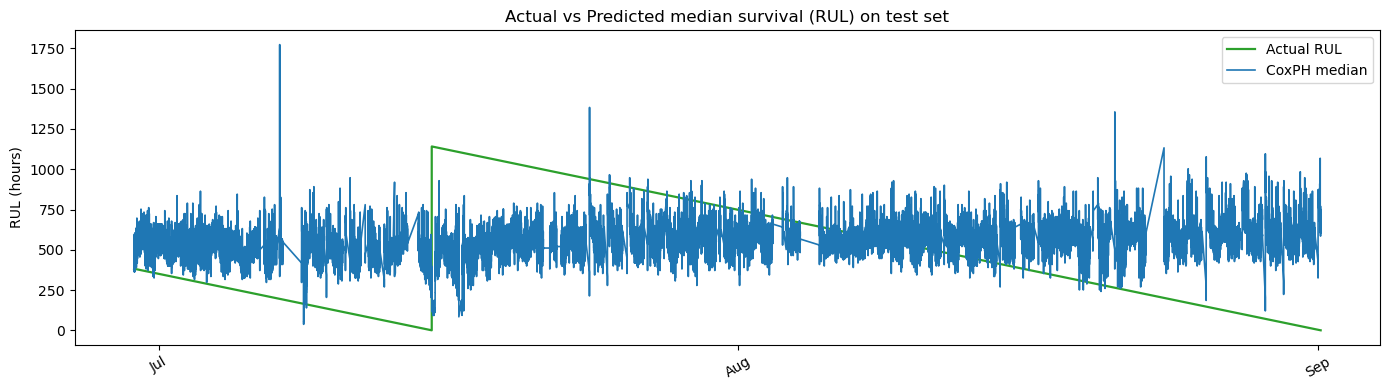


[INFO] Evaluation complete. Models available in `models`, predictions in `predictions`.


In [6]:
# Evaluation and visualization for survival models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lifelines.utils import concordance_index

# Use test_df and predictions from previous cell
test_times = test_df["timestamp"].to_numpy()
y_true = test_df["duration"].to_numpy()
event_test = test_df["event"].to_numpy()

# Choose which prediction to evaluate (cox first, rsf if available)
pred_cox = predictions.get("cox_median", None)
pred_rsf = predictions.get("rsf_median", None)

def print_metrics(name, pred):
    if pred is None:
        print(f"{name}: no predictions")
        return
    mae = mean_absolute_error(y_true, pred)
    cidx = concordance_index(y_true, -pred, event_test)
    print(f"{name} MAE = {mae:.2f} hours; C-index = {cidx:.3f}")

print_metrics("CoxPH median", pred_cox)
print_metrics("RSF median", pred_rsf)

# Plot actual vs predicted RUL time series (use Cox and RSF if available)
plt.figure(figsize=(14,4))
plt.plot(test_times, y_true, color="#2ca02c", lw=1.6, label="Actual RUL")
if pred_cox is not None:
    plt.plot(test_times, pred_cox, color="#1f77b4", lw=1.2, label="CoxPH median")
if pred_rsf is not None:
    plt.plot(test_times, pred_rsf, color="#ff7f0e", lw=1.2, label="RSF median")
plt.ylabel("RUL (hours)")
plt.title("Actual vs Predicted median survival (RUL) on test set")
plt.legend(loc="upper right")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



# Per-cycle detection stats using median as alarm threshold
# Alarm if predicted median <= H hours (early warning)
H_warn = 48
def per_cycle_detection(cycles_list, timestamps_test, pred_median, y_bin, threshold=48):
    timestamps_test = pd.to_datetime(timestamps_test)
    rows = []
    for idx, cycle in enumerate(cycles_list[2:], start=3):
        if cycle is None or cycle.empty:
            rows.append((idx, 0, None, None)); continue
        start_ts = pd.to_datetime(cycle["timestamp"].min())
        end_ts = pd.to_datetime(cycle["timestamp"].max())
        mask = (timestamps_test >= start_ts) & (timestamps_test <= end_ts)
        if not mask.any():
            rows.append((idx, 0, None, None)); continue
        y_c = y_bin[mask]
        pos_mask = (y_c == 1)
        if pos_mask.sum() == 0:
            rows.append((idx, int(pos_mask.sum()), None, None)); continue
        pred_c = (pred_median[mask] <= threshold).astype(int)
        # compute recall on positive rows
        from sklearn.metrics import recall_score
        recall_c = float(recall_score(y_c[pos_mask], pred_c[pos_mask], zero_division=0))
        # time-to-first-detection: find first pred==1 among pos rows and return RUL at that row
        cycle_rul = cycle["RUL_hours"].to_numpy()
        if cycle_rul.shape[0] == mask.sum():
            rul_c = cycle_rul
        else:
            rul_map = {str(ts): float(r) for ts, r in zip(pd.to_datetime(cycle["timestamp"]).to_numpy(), cycle["RUL_hours"].to_numpy())}
            rul_c = np.array([rul_map.get(str(ts), np.nan) for ts in timestamps_test[mask]], dtype=float)
        detected_pos = np.where(pred_c[pos_mask] == 1)[0]
        if len(detected_pos) == 0:
            ttf = None
        else:
            pos_indices = np.where(pos_mask)[0]
            first_detect_rel = pos_indices[detected_pos[0]]
            ttf = float(rul_c[first_detect_rel]) if not np.isnan(rul_c[first_detect_rel]) else None
        rows.append((idx, int(pos_mask.sum()), recall_c, ttf))
    return rows



# End of evaluation cell
print("\n[INFO] Evaluation complete. Models available in `models`, predictions in `predictions`.")


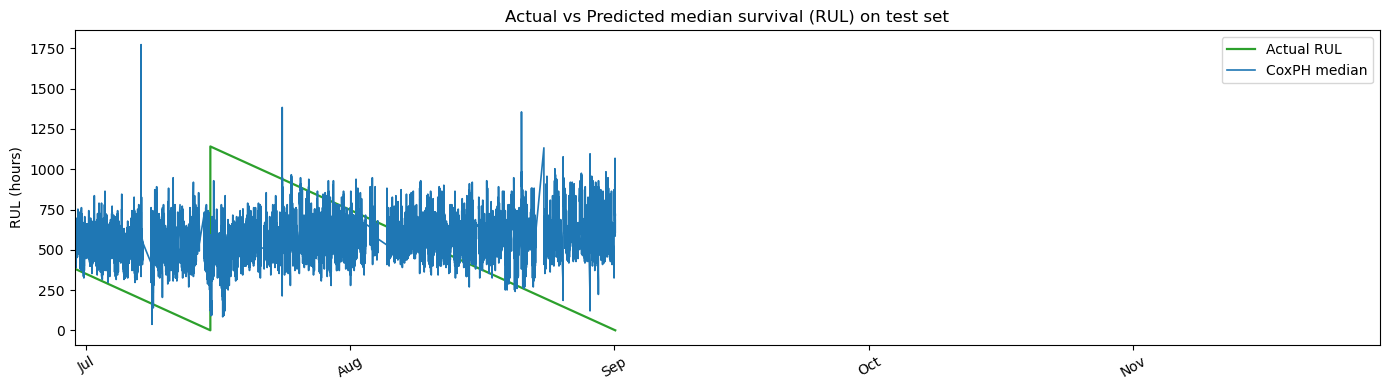

In [7]:
import matplotlib.dates as mdates

# Plot actual vs predicted RUL time series (use Cox and RSF if available)
plt.figure(figsize=(14,4))
plt.plot(test_times, y_true, color="#2ca02c", lw=1.6, label="Actual RUL")
if pred_cox is not None:
    plt.plot(test_times, pred_cox, color="#1f77b4", lw=1.2, label="CoxPH median")
if pred_rsf is not None:
    plt.plot(test_times, pred_rsf, color="#ff7f0e", lw=1.2, label="RSF median")
plt.ylabel("RUL (hours)")
plt.title("Actual vs Predicted median survival (RUL) on test set")
plt.legend(loc="upper right")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.xticks(rotation=30)

# Force the x-axis to extend through November
end_of_nov = pd.to_datetime("2020-11-30")  # adjust year if needed
ax.set_xlim(left=test_times.min(), right=end_of_nov)

plt.tight_layout()
plt.show()


[INFO] Segmenting dataset into cycles...
[INFO] Cycle 1 segmented: 18725 rows
[INFO] Cycle 2 segmented: 9388 rows
[INFO] Cycle 3 segmented: 1663 rows
[INFO] Cycle 4 segmented: 9478 rows
[INFO] Cycle 1 RUL range: 0.04 to 1847.96
[INFO] Cycle 2 RUL range: 0.04 to 1007.46
[INFO] Cycle 3 RUL range: 0.04 to 154.46
[INFO] Cycle 4 RUL range: 0.00 to 964.46
[INFO] Building features for Train with window=60...
[INFO] Train features: 28113 rows, 24 features in 0.0s
[INFO] Building features for Test with window=60...
[INFO] Test features: 11141 rows, 24 features in 0.0s
[INFO] Train size: (28113, 24), Test size: (11141, 24)
[INFO] Training GradientBoostingRegressor...
[INFO] Training complete in 49.0s.
[INFO] Evaluating model...
[RESULT] GBR (smoothed) MAE: 259.64 hours, RMSE: 312.14 hours
[INFO] Plotting results...


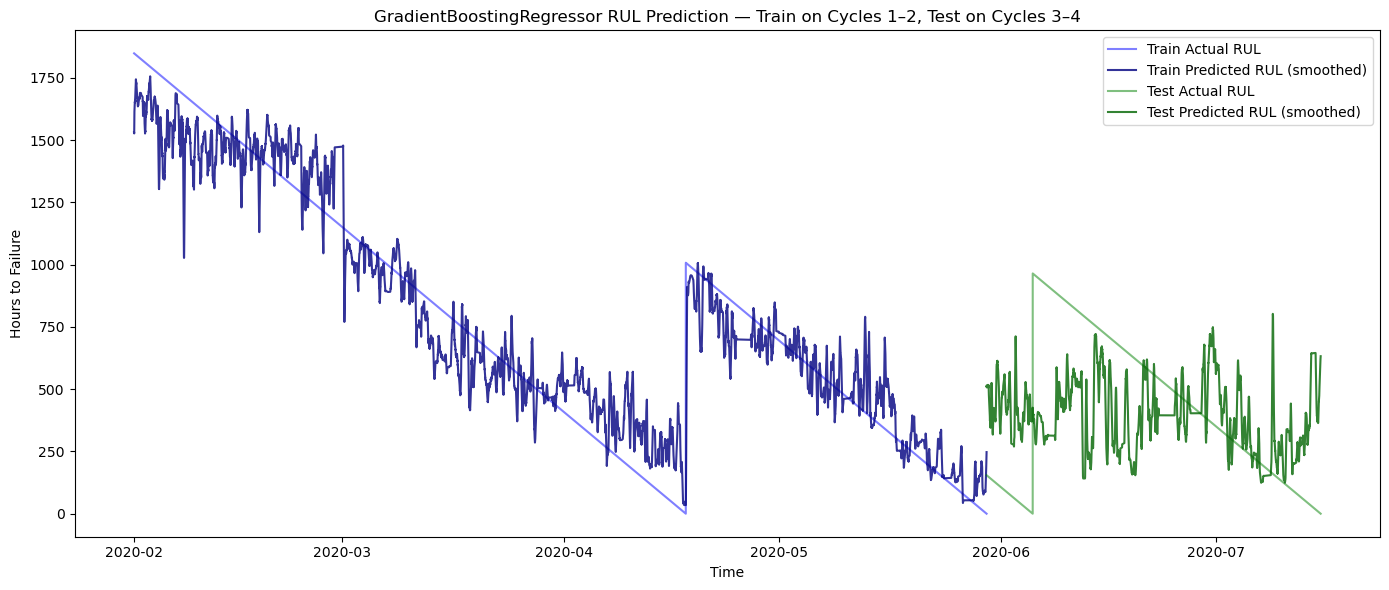

[INFO] Pipeline complete.


In [8]:
# GBR TRAINING CELL

import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Helper functions ---
def add_roll_feats(s, prefix, win):
    return pd.DataFrame({
        f"{prefix}_mean": s.rolling(win, min_periods=5).mean(),
        f"{prefix}_std":  s.rolling(win, min_periods=5).std(),
        f"{prefix}_roc":  s.diff(),
    })

def build_features(df_cycle, win=60, cycle_id=None):
    print(f"[INFO] Building features for {cycle_id} with window={win}...")
    start_time = time.time()
    feat_frames = []
    for col in ["Motor_current","Oil_temperature","TP2","TP3","H1","DV_pressure","Reservoirs"]:
        feat_frames.append(add_roll_feats(df_cycle[col], col, win))
    for col in ["COMP","MPG","LPS"]:
        feat_frames.append(pd.DataFrame({f"{col}_duty": df_cycle[col].rolling(win, min_periods=5).mean()}))
    X = pd.concat(feat_frames, axis=1)
    y = df_cycle["RUL_hours"].astype("float32")
    valid = ~y.isna()
    # Use ffill/bfill instead of deprecated fillna(method=...)
    X = X.loc[valid].ffill().bfill()
    y = y.loc[valid]
    t = df_cycle.loc[valid, "timestamp"]
    print(f"[INFO] {cycle_id} features: {X.shape[0]} rows, {X.shape[1]} features in {time.time()-start_time:.1f}s")
    return X, y, t

# --- Segment dataset into cycles using explicit failure_starts ---
print("[INFO] Segmenting dataset into cycles...")
cycles = []

# Cycle 1: start → first failure
start_time = df["timestamp"].min()
end_time = failure_starts[0]
cycle1 = df[(df["timestamp"] <= end_time)].copy()
cycles.append(cycle1)

# Subsequent cycles between failures
for i in range(1, len(failure_starts)):
    prev_fail = failure_starts[i-1]
    this_fail = failure_starts[i]
    cycle = df[(df["timestamp"] > prev_fail) & (df["timestamp"] <= this_fail)].copy()
    cycles.append(cycle)

# Downsample each cycle
for i, c in enumerate(cycles, start=1):
    if len(c) > 0:
        c = c.set_index("timestamp").resample("5min").mean().dropna().reset_index()
        cycles[i-1] = c
    print(f"[INFO] Cycle {i} segmented: {len(c)} rows")

# RUL sanity check
for i, c in enumerate(cycles, start=1):
    if len(c) > 0:
        print(f"[INFO] Cycle {i} RUL range: {c['RUL_hours'].min():.2f} to {c['RUL_hours'].max():.2f}")

# Train/test split
train_cycles = pd.concat(cycles[:2], ignore_index=True)
test_cycles = pd.concat(cycles[2:], ignore_index=True)

X_train, y_train, t_train = build_features(train_cycles, win=60, cycle_id="Train")
X_test, y_test, t_test = build_features(test_cycles, win=60, cycle_id="Test")

print(f"[INFO] Train size: {X_train.shape}, Test size: {X_test.shape}")

# --- Train GBR ---
print("[INFO] Training GradientBoostingRegressor...")
start_time = time.time()
gbr = GradientBoostingRegressor(
    n_estimators=500,   # more trees
    max_depth=3,
    learning_rate=0.05, # smaller step size
    subsample=0.8,
    random_state=42
)
gbr.fit(X_train, y_train)
print(f"[INFO] Training complete in {time.time()-start_time:.1f}s.")

# --- Evaluate ---
print("[INFO] Evaluating model...")
pred_train = gbr.predict(X_train)
pred_test = gbr.predict(X_test)

# Smooth predictions
pred_train_smoothed = pd.Series(pred_train, index=t_train).rolling(50, min_periods=1).mean()
pred_test_smoothed = pd.Series(pred_test, index=t_test).rolling(50, min_periods=1).mean()

mae_gbr = mean_absolute_error(y_test, pred_test_smoothed)
rmse_gbr = np.sqrt(mean_squared_error(y_test, pred_test_smoothed))
print(f"[RESULT] GBR (smoothed) MAE: {mae_gbr:.2f} hours, RMSE: {rmse_gbr:.2f} hours")

# --- Plot with clear colors ---
print("[INFO] Plotting results...")
plt.figure(figsize=(14,6))

plt.plot(t_train, y_train, color="blue", label="Train Actual RUL", alpha=0.5)
plt.plot(pred_train_smoothed.index, pred_train_smoothed.values, color="navy", label="Train Predicted RUL (smoothed)", alpha=0.8)

plt.plot(t_test, y_test, color="green", label="Test Actual RUL", alpha=0.5)
plt.plot(pred_test_smoothed.index, pred_test_smoothed.values, color="darkgreen", label="Test Predicted RUL (smoothed)", alpha=0.8)

plt.title("GradientBoostingRegressor RUL Prediction — Train on Cycles 1–2, Test on Cycles 3–4")
plt.xlabel("Time")
plt.ylabel("Hours to Failure")
plt.legend()
plt.tight_layout()
plt.show()
print("[INFO] Pipeline complete.")


[RESULT] Dynamic Ensemble MAE: 273.82, RMSE: 315.70


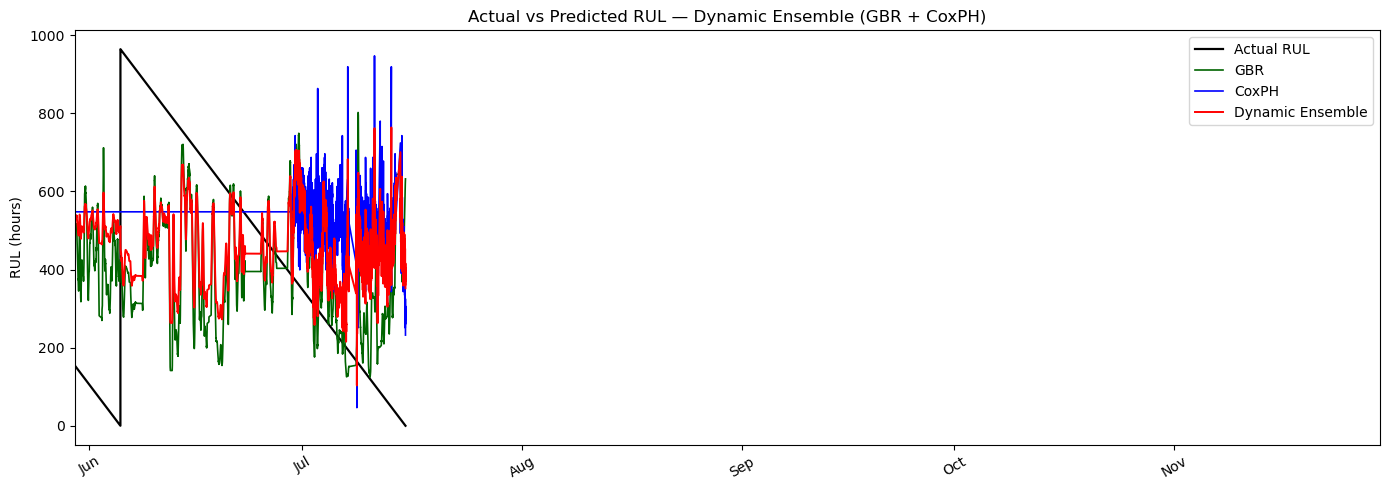

In [9]:
# --- Dynamic Ensemble of GBR + CoxPH for RUL prediction ---

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assume you already have:
# - pred_test_smoothed (GBR predictions on test set, smoothed)
# - t_test (timestamps for test set)
# - y_test (actual RUL for test set)
# - pred_cox (CoxPH median predictions aligned with test_df["timestamp"])
# - test_df with "timestamp"

# Align Cox predictions to GBR timestamps
pred_cox_series = pd.Series(pred_cox, index=pd.to_datetime(test_df["timestamp"]))
pred_cox_aligned = pred_cox_series.reindex(t_test, method="nearest")

# --- Dynamic weighting ---
# More Cox weight when RUL is short (<200h), more GBR weight when RUL is long
weights_cox = np.where(y_test < 200, 0.7, 0.3)
weights_gbr = 1 - weights_cox

pred_dynamic = weights_gbr * pred_test_smoothed.values + weights_cox * pred_cox_aligned.values

# --- Evaluate ensemble ---
mae_dyn = mean_absolute_error(y_test, pred_dynamic)
rmse_dyn = np.sqrt(mean_squared_error(y_test, pred_dynamic))

print(f"[RESULT] Dynamic Ensemble MAE: {mae_dyn:.2f}, RMSE: {rmse_dyn:.2f}")

# --- Plot actual vs predicted RUL time series ---
plt.figure(figsize=(14,5))
plt.plot(t_test, y_test, color="black", lw=1.6, label="Actual RUL")
plt.plot(pred_test_smoothed.index, pred_test_smoothed.values, color="darkgreen", lw=1.2, label="GBR")
plt.plot(pred_cox_aligned.index, pred_cox_aligned.values, color="blue", lw=1.2, label="CoxPH")
plt.plot(t_test, pred_dynamic, color="red", lw=1.4, label="Dynamic Ensemble")

plt.ylabel("RUL (hours)")
plt.title("Actual vs Predicted RUL — Dynamic Ensemble (GBR + CoxPH)")
plt.legend(loc="upper right")

# Format x-axis by month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.xticks(rotation=30)

# Force the x-axis to extend through November (adjust year if needed)
end_of_nov = pd.to_datetime("2020-11-30")
ax.set_xlim(left=t_test.min(), right=end_of_nov)

plt.tight_layout()
plt.show()


[INFO] Segmenting dataset into cycles...
[INFO] Cycle 1 segmented: 18725 rows
[INFO] Cycle 2 segmented: 9388 rows
[INFO] Cycle 3 segmented: 1663 rows
[INFO] Cycle 4 segmented: 9478 rows
[INFO] Cycle 1 RUL range: 0.04 to 1847.96
[INFO] Cycle 2 RUL range: 0.04 to 1007.46
[INFO] Cycle 3 RUL range: 0.04 to 154.46
[INFO] Cycle 4 RUL range: 0.00 to 964.46
[INFO] Building features for Train with window=60...
[INFO] Train features: 28113 rows, 25 features in 0.0s
[INFO] Building features for Test with window=60...
[INFO] Test features: 11141 rows, 25 features in 0.0s
[INFO] Train size: (28113, 25), Test size: (11141, 25)
[INFO] Training GradientBoostingRegressor...
[INFO] Training complete in 50.9s.
[INFO] Evaluating model...
[RESULT] GBR (smoothed) MAE: 875.39 hours, RMSE: 940.35 hours
[INFO] Plotting results...


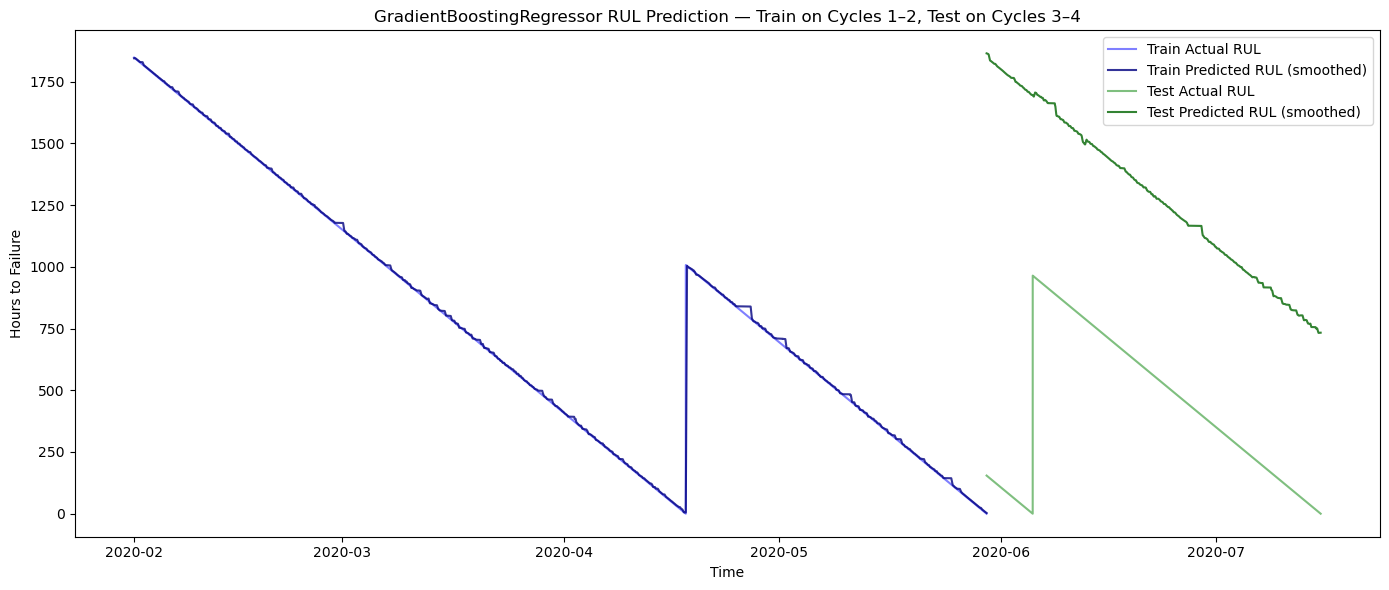

[INFO] Pipeline complete.


In [10]:
# GBR TRAINING CELL (with time_since_cycle_start restored)

import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Helper functions ---
def add_roll_feats(s, prefix, win):
    return pd.DataFrame({
        f"{prefix}_mean": s.rolling(win, min_periods=5).mean(),
        f"{prefix}_std":  s.rolling(win, min_periods=5).std(),
        f"{prefix}_roc":  s.diff(),
    })

def build_features(df_cycle, win=60, cycle_id=None):
    print(f"[INFO] Building features for {cycle_id} with window={win}...")
    start_time = time.time()
    feat_frames = []
    # Rolling features for analog sensors
    for col in ["Motor_current","Oil_temperature","TP2","TP3","H1","DV_pressure","Reservoirs"]:
        feat_frames.append(add_roll_feats(df_cycle[col], col, win))
    # Duty cycle features for digital signals
    for col in ["COMP","MPG","LPS"]:
        feat_frames.append(pd.DataFrame({f"{col}_duty": df_cycle[col].rolling(win, min_periods=5).mean()}))
    # Add time_since_cycle_start feature
    cycle_start = df_cycle["timestamp"].min()
    time_since = (df_cycle["timestamp"] - cycle_start).dt.total_seconds() / 3600.0
    feat_frames.append(pd.DataFrame({"time_since_cycle_start": time_since}))
    # Concatenate all features
    X = pd.concat(feat_frames, axis=1)
    y = df_cycle["RUL_hours"].astype("float32")
    valid = ~y.isna()
    X = X.loc[valid].ffill().bfill()
    y = y.loc[valid]
    t = df_cycle.loc[valid, "timestamp"]
    print(f"[INFO] {cycle_id} features: {X.shape[0]} rows, {X.shape[1]} features in {time.time()-start_time:.1f}s")
    return X, y, t

# --- Segment dataset into cycles using explicit failure_starts ---
print("[INFO] Segmenting dataset into cycles...")
cycles = []

# Cycle 1: start → first failure
start_time = df["timestamp"].min()
end_time = failure_starts[0]
cycle1 = df[(df["timestamp"] <= end_time)].copy()
cycles.append(cycle1)

# Subsequent cycles between failures
for i in range(1, len(failure_starts)):
    prev_fail = failure_starts[i-1]
    this_fail = failure_starts[i]
    cycle = df[(df["timestamp"] > prev_fail) & (df["timestamp"] <= this_fail)].copy()
    cycles.append(cycle)

# Downsample each cycle
for i, c in enumerate(cycles, start=1):
    if len(c) > 0:
        c = c.set_index("timestamp").resample("5min").mean().dropna().reset_index()
        cycles[i-1] = c
    print(f"[INFO] Cycle {i} segmented: {len(c)} rows")

# RUL sanity check
for i, c in enumerate(cycles, start=1):
    if len(c) > 0:
        print(f"[INFO] Cycle {i} RUL range: {c['RUL_hours'].min():.2f} to {c['RUL_hours'].max():.2f}")

# Train/test split
train_cycles = pd.concat(cycles[:2], ignore_index=True)
test_cycles = pd.concat(cycles[2:], ignore_index=True)

X_train, y_train, t_train = build_features(train_cycles, win=60, cycle_id="Train")
X_test, y_test, t_test = build_features(test_cycles, win=60, cycle_id="Test")

print(f"[INFO] Train size: {X_train.shape}, Test size: {X_test.shape}")

# --- Train GBR ---
print("[INFO] Training GradientBoostingRegressor...")
start_time = time.time()
gbr = GradientBoostingRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)
gbr.fit(X_train, y_train)
print(f"[INFO] Training complete in {time.time()-start_time:.1f}s.")

# --- Evaluate ---
print("[INFO] Evaluating model...")
pred_train = gbr.predict(X_train)
pred_test = gbr.predict(X_test)

# Smooth predictions
pred_train_smoothed = pd.Series(pred_train, index=t_train).rolling(50, min_periods=1).mean()
pred_test_smoothed = pd.Series(pred_test, index=t_test).rolling(50, min_periods=1).mean()

mae_gbr = mean_absolute_error(y_test, pred_test_smoothed)
rmse_gbr = np.sqrt(mean_squared_error(y_test, pred_test_smoothed))
print(f"[RESULT] GBR (smoothed) MAE: {mae_gbr:.2f} hours, RMSE: {rmse_gbr:.2f} hours")

# --- Plot with clear colors ---
print("[INFO] Plotting results...")
plt.figure(figsize=(14,6))

plt.plot(t_train, y_train, color="blue", label="Train Actual RUL", alpha=0.5)
plt.plot(pred_train_smoothed.index, pred_train_smoothed.values, color="navy", label="Train Predicted RUL (smoothed)", alpha=0.8)

plt.plot(t_test, y_test, color="green", label="Test Actual RUL", alpha=0.5)
plt.plot(pred_test_smoothed.index, pred_test_smoothed.values, color="darkgreen", label="Test Predicted RUL (smoothed)", alpha=0.8)

plt.title("GradientBoostingRegressor RUL Prediction — Train on Cycles 1–2, Test on Cycles 3–4")
plt.xlabel("Time")
plt.ylabel("Hours to Failure")
plt.legend()
plt.tight_layout()
plt.show()
print("[INFO] Pipeline complete.")


[RESULT] GBR (improved) MAE: 875.39, RMSE: 940.35
[RESULT] CoxPH MAE: 267.42, RMSE: 309.42
[RESULT] Dynamic Ensemble MAE: 555.61, RMSE: 571.38


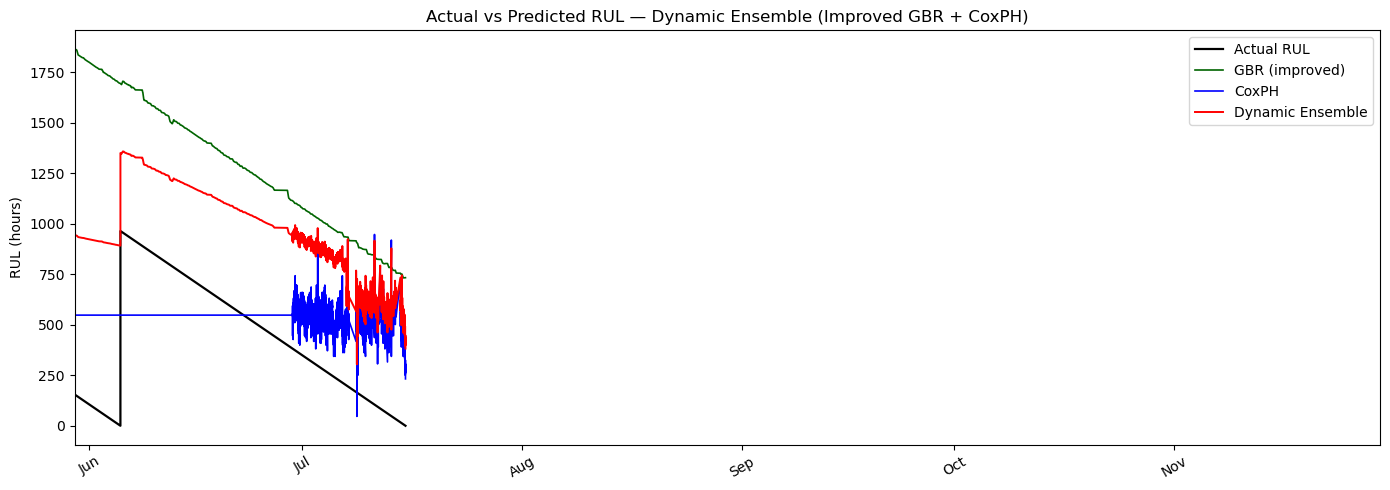

In [11]:
# --- Dynamic Ensemble of Improved GBR + CoxPH for RUL prediction ---

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assume you already have:
# - pred_test_smoothed (GBR predictions on test set, smoothed, with time_since_cycle_start included)
# - t_test (timestamps for test set)
# - y_test (actual RUL for test set)
# - pred_cox (CoxPH median predictions aligned with test_df["timestamp"])
# - test_df with "timestamp"

# Align Cox predictions to GBR timestamps
pred_cox_series = pd.Series(pred_cox, index=pd.to_datetime(test_df["timestamp"]))
pred_cox_aligned = pred_cox_series.reindex(t_test, method="nearest")

# --- Dynamic weighting ---
# More Cox weight when RUL is short (<200h), more GBR weight when RUL is long
weights_cox = np.where(y_test < 200, 0.7, 0.3)
weights_gbr = 1 - weights_cox

pred_dynamic = weights_gbr * pred_test_smoothed.values + weights_cox * pred_cox_aligned.values

# --- Evaluate ensemble ---
mae_gbr = mean_absolute_error(y_test, pred_test_smoothed)
rmse_gbr = np.sqrt(mean_squared_error(y_test, pred_test_smoothed))
mae_cox = mean_absolute_error(y_test, pred_cox_aligned)
rmse_cox = np.sqrt(mean_squared_error(y_test, pred_cox_aligned))
mae_dyn = mean_absolute_error(y_test, pred_dynamic)
rmse_dyn = np.sqrt(mean_squared_error(y_test, pred_dynamic))

print(f"[RESULT] GBR (improved) MAE: {mae_gbr:.2f}, RMSE: {rmse_gbr:.2f}")
print(f"[RESULT] CoxPH MAE: {mae_cox:.2f}, RMSE: {rmse_cox:.2f}")
print(f"[RESULT] Dynamic Ensemble MAE: {mae_dyn:.2f}, RMSE: {rmse_dyn:.2f}")

# --- Plot actual vs predicted RUL time series ---
plt.figure(figsize=(14,5))
plt.plot(t_test, y_test, color="black", lw=1.6, label="Actual RUL")
plt.plot(pred_test_smoothed.index, pred_test_smoothed.values, color="darkgreen", lw=1.2, label="GBR (improved)")
plt.plot(pred_cox_aligned.index, pred_cox_aligned.values, color="blue", lw=1.2, label="CoxPH")
plt.plot(t_test, pred_dynamic, color="red", lw=1.4, label="Dynamic Ensemble")

plt.ylabel("RUL (hours)")
plt.title("Actual vs Predicted RUL — Dynamic Ensemble (Improved GBR + CoxPH)")
plt.legend(loc="upper right")

# Format x-axis by month
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.xticks(rotation=30)

# Force the x-axis to extend through November (adjust year if needed)
end_of_nov = pd.to_datetime("2020-11-30")
ax.set_xlim(left=t_test.min(), right=end_of_nov)

plt.tight_layout()
plt.show()
